In [1]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import random
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn_image as isns

sns.set_style("darkgrid")
isns.set_image(origin="upper")

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from utils import CustomImageDataset
from tqdm.notebook import tqdm

import os


from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
train_dataset = CustomImageDataset("./data/train_data.csv", normalize=True, batch_size=2000, device=device)
test_dataset = CustomImageDataset("./data/test_data.csv", normalize=True, batch_size=2000, device=device)

In [4]:
train_dataset[0][0].device

device(type='cuda', index=0)

## Dense Autoencoder

In [4]:
code_size = 64

encoder = EncoderDense(train_dataset[0][0].shape[1:], code_size, device=device)
decoder = DecoderDense(code_size, train_dataset[0][0].shape[1:], device=device)
autoencoder = DenseAE(encoder, decoder)
autoencoder

DenseAE(
  (encoder): EncoderDense(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=64, bias=True)
    (relu): ReLU()
  )
  (decoder): DecoderDense(
    (layer1): Linear(in_features=64, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

torch.Size([28, 28])


<Axes: >

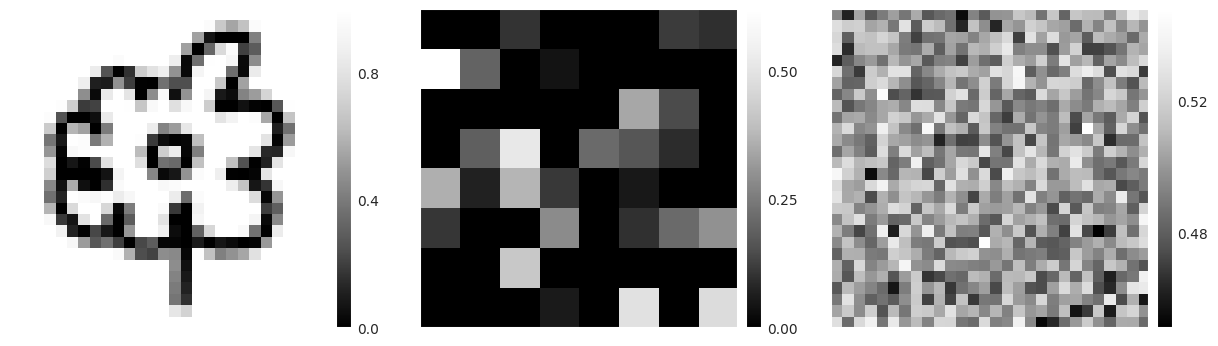

In [5]:
example_img = random.choice(train_dataset)
encoded_tensor = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)

fig, ax = plt.subplots(1,3, figsize=(15,15))
print(example_img[0][0].shape)
isns.imgplot(example_img[0][0].to("cpu").detach().numpy(), cmap="Greys_r", ax=ax[0])
isns.imgplot(encoded_tensor[0].to("cpu").detach().numpy().reshape((8,8)), cmap="Greys_r", ax=ax[1])
isns.imgplot(decoded_tensor[0].to("cpu").detach().numpy(), cmap="Greys_r", ax=ax[2])


In [6]:
learning_rate = 1e-3
epochs = 500

loss_fn = nn.BCELoss()
print(loss_fn)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

BCELoss()


In [7]:
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        pred = autoencoder(X)

        loss = loss_fn(pred, X)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            pred = autoencoder(X)

            test_loss += loss_fn(pred, X).item()

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")


Epoch   1/500: Train loss: 0.669920, Test loss: 0.609464
Epoch   2/500: Train loss: 0.550973, Test loss: 0.474252
Epoch   3/500: Train loss: 0.445253, Test loss: 0.398384
Epoch   4/500: Train loss: 0.392925, Test loss: 0.374714
Epoch   5/500: Train loss: 0.377009, Test loss: 0.366286
Epoch   6/500: Train loss: 0.370385, Test loss: 0.363188
Epoch   7/500: Train loss: 0.367773, Test loss: 0.361106
Epoch   8/500: Train loss: 0.366130, Test loss: 0.359725
Epoch   9/500: Train loss: 0.365106, Test loss: 0.358914
Epoch  10/500: Train loss: 0.364478, Test loss: 0.358348
Epoch  11/500: Train loss: 0.364049, Test loss: 0.358037
Epoch  12/500: Train loss: 0.363825, Test loss: 0.357776
Epoch  13/500: Train loss: 0.363591, Test loss: 0.357609
Epoch  14/500: Train loss: 0.363418, Test loss: 0.357444
Epoch  15/500: Train loss: 0.363267, Test loss: 0.357270
Epoch  16/500: Train loss: 0.363125, Test loss: 0.357088
Epoch  17/500: Train loss: 0.362986, Test loss: 0.356907
Epoch  18/500: Train loss: 0.36

torch.Size([28, 28])


<Axes: >

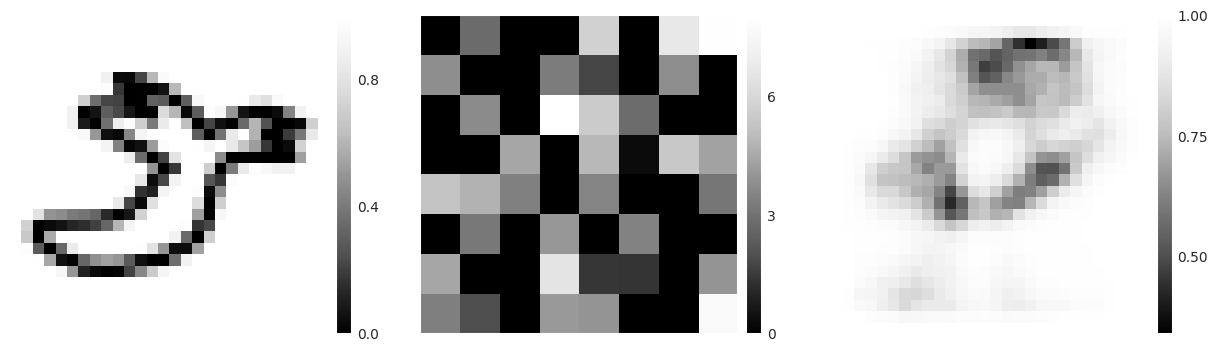

In [13]:
example_img = random.choice(train_dataset)
encoded_tensor = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((8,8))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0])
isns.imgplot(code, cmap="Greys_r", ax=ax[1])
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2])


## VAE

In [3]:
code_size = 64

encoder = EncoderDenseVAE(train_dataset[0][0].shape[1:], code_size, device=device)
decoder = DecoderDenseVAE(code_size, train_dataset[0][0].shape[1:], device=device)
autoencoder = DenseVAE(encoder, decoder, beta=0.01)
autoencoder

DenseVAE(
  (encoder): EncoderDenseVAE(
    (layer1): Linear(in_features=784, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=64, bias=True)
    (layer3): Linear(in_features=100, out_features=64, bias=True)
    (relu): ReLU()
  )
  (decoder): DecoderDenseVAE(
    (layer1): Linear(in_features=64, out_features=100, bias=True)
    (layer2): Linear(in_features=100, out_features=784, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
)

In [5]:
learning_rate = 1e-3
epochs = 100

loss_fn = nn.BCELoss()
print(loss_fn)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

BCELoss()


In [6]:
for i in range(epochs):
    
    print(f"Epoch {i+1:3d}/{epochs}: ", end="")

    # Train
    autoencoder.train()
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataset):
        loss = autoencoder.update((X,y))
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataset:
            loss = autoencoder.update((X,y))
            test_loss += loss.item()

    print(f"Train loss: {train_loss/len(train_dataset):>7f}, Test loss: {test_loss/len(test_dataset):>7f}")

Epoch   1/100: Train loss: 0.219103, Test loss: 0.197801
Epoch   2/100: Train loss: 0.188481, Test loss: 0.176225
Epoch   3/100: Train loss: 0.167414, Test loss: 0.155859
Epoch   4/100: Train loss: 0.147798, Test loss: 0.137158
Epoch   5/100: Train loss: 0.131088, Test loss: 0.122622
Epoch   6/100: Train loss: 0.118332, Test loss: 0.111843
Epoch   7/100: Train loss: 0.109289, Test loss: 0.104382
Epoch   8/100: Train loss: 0.103239, Test loss: 0.099503
Epoch   9/100: Train loss: 0.099246, Test loss: 0.096530
Epoch  10/100: Train loss: 0.096638, Test loss: 0.094624
Epoch  11/100: Train loss: 0.094948, Test loss: 0.093059
Epoch  12/100: Train loss: 0.093585, Test loss: 0.092042
Epoch  13/100: Train loss: 0.092651, Test loss: 0.091226
Epoch  14/100: Train loss: 0.091877, Test loss: 0.090335
Epoch  15/100: Train loss: 0.091327, Test loss: 0.089921
Epoch  16/100: Train loss: 0.090760, Test loss: 0.089381
Epoch  17/100: Train loss: 0.090329, Test loss: 0.089045
Epoch  18/100: Train loss: 0.08

torch.Size([28, 28])


<Axes: >

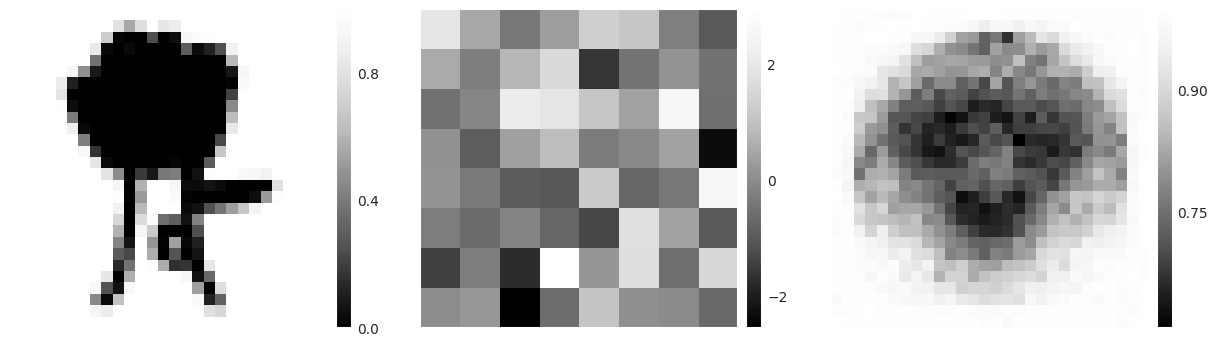

In [9]:
example_img = random.choice(train_dataset)
encoded_tensor, z_loc, z_log_scale = encoder(example_img[0])
decoded_tensor = decoder(encoded_tensor)


fig, ax = plt.subplots(1,3, figsize=(15,15))
print(random.choice(example_img[0]).shape)

rand_idx = random.choice(range(len(example_img[0])))

ex_img = example_img[0][rand_idx+1].to("cpu")
code = encoded_tensor[rand_idx].to("cpu").detach().numpy().reshape((8,8))
decoded = decoded_tensor[rand_idx].to("cpu").detach().numpy()
isns.imgplot(ex_img, cmap="Greys_r", ax=ax[0])
isns.imgplot(code, cmap="Greys_r", ax=ax[1])
isns.imgplot(decoded, cmap="Greys_r", ax=ax[2])